# Bad Controls and Colliders

**Chapter 7, Section 2**

This notebook covers variables that should NOT be controlled for, including treatment predictors and colliders.

## Table of Contents
1. [Intuition](#intuition) - When controls hurt
2. [Formal Treatment](#formal) - SE inflation mechanism
3. [Numeric Demonstration](#numeric) - Hospital example
4. [Implementation](#implementation) - Detecting bad controls
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### When Controls Make Things Worse

Not all pre-treatment variables should be controlled for. A variable can be **harmful** as a control if:

1. **Treatment Predictor**: Predicts T but not Y (given confounders)
   - Removes treatment variation → inflates SE
   - Doesn't reduce residual variance

2. **Collider**: Caused by BOTH T and Y (or their consequences)
   - Conditioning opens a spurious path
   - Introduces bias, not just inefficiency

★ Insight ─────────────────────────────────────
- Bad control reduces Var(T̃) without reducing Var(ε)
- SE(β̂) ∝ σ_ε / √Var(T̃) → denominator shrinks, SE increases
- Colliders are worse: they introduce BIAS, not just inefficiency
─────────────────────────────────────────────────

In [2]:
# Load hospital treatment data
hospital = load_facure_data("hospital_treatment.csv")

print(f"Data: {len(hospital)} patients")
print(f"\nColumns: {list(hospital.columns)}")
hospital.describe()

Data: 80 patients

Columns: ['hospital', 'treatment', 'severity', 'days']


,hospital,treatment,severity,days
count,80.0000,80.0000,80.0000,80.0000
mean,0.6375,0.6250,15.4758,42.1125
std,0.4838,0.4872,7.1915,16.0434
min,0.0000,0.0000,-4.0304,0.0000
25%,0.0000,0.0000,9.8433,30.7500
50%,1.0000,1.0000,16.6409,44.5000
75%,1.0000,1.0000,20.5935,52.0000
max,1.0000,1.0000,31.0674,82.0000


In [3]:
# Understand the DAG:
# Severity → Treatment (sicker patients get treated)
# Severity → Days (sicker patients stay longer)
# Treatment → Days (treatment reduces stay)
# Hospital → Treatment (some hospitals treat more aggressively)
# BUT: Hospital ↛ Days (after conditioning on severity)

print("Correlation matrix:")
print(hospital.corr().round(3))

Correlation matrix:
           hospital  treatment  severity   days
hospital     1.0000     0.8660    0.7950 0.5910
treatment    0.8660     1.0000    0.6480 0.4300
severity     0.7950     0.6480    1.0000 0.8700
days         0.5910     0.4300    0.8700 1.0000


---

## Formal Treatment

### Why Bad Controls Inflate Standard Errors

Recall the SE formula for $\hat{\beta}_T$:

$$SE(\hat{\beta}_T) = \sqrt{\frac{\hat{\sigma}^2_{\epsilon}}{\text{SST}_T \cdot (1 - R^2_{T \sim X})}}$$

where $\text{SST}_T = \sum_i (T_i - \bar{T})^2$ is total treatment variation.

**Decomposing the effect of adding control X**:

| If X predicts... | $\hat{\sigma}^2_{\epsilon}$ | $R^2_{T \sim X}$ | Net SE effect |
|-----------------|---------------------------|-----------------|---------------|
| Y strongly, T weakly | ↓ Decreases | ↑ Small increase | **↓ Decreases** |
| T strongly, Y weakly | → No change | ↑ Large increase | **↑ Increases** |
| Both | ↓ Decreases | ↑ Increases | Depends |

### The Denominator Problem

By FWL, $\hat{\beta}_T$ comes from:
$$\tilde{Y} = \beta_T \tilde{T} + \epsilon$$

The SE is:
$$SE(\hat{\beta}_T) \propto \frac{1}{\sqrt{\text{Var}(\tilde{T})}}$$

If X predicts T, then $\text{Var}(\tilde{T}) < \text{Var}(T)$, making the denominator smaller → SE larger.

In [4]:
# Model 1: Correct specification (control for confounder only)
model_correct = smf.ols('days ~ treatment + severity', data=hospital).fit()

# Model 2: Add hospital (predicts treatment but not outcome|severity)
model_bad_control = smf.ols('days ~ treatment + severity + hospital', data=hospital).fit()

print("COMPARISON: Correct vs Bad Control")
print("=" * 55)
print(f"\nTreatment Effect (treatment → days):")
print(f"  Correct (+ severity):          {model_correct.params['treatment']:.2f} (SE: {model_correct.bse['treatment']:.2f})")
print(f"  Bad control (+ hospital):      {model_bad_control.params['treatment']:.2f} (SE: {model_bad_control.bse['treatment']:.2f})")
print(f"\nSE INCREASE: {(model_bad_control.bse['treatment']/model_correct.bse['treatment'] - 1)*100:.1f}%")

COMPARISON: Correct vs Bad Control

Treatment Effect (treatment → days):
  Correct (+ severity):          -7.59 (SE: 2.27)
  Bad control (+ hospital):      -5.09 (SE: 3.49)

SE INCREASE: 53.9%


---

## Numeric Demonstration

### Why Hospital is a Bad Control

In [5]:
# Check: Does hospital predict treatment?
model_T_on_hospital = smf.ols('treatment ~ hospital', data=hospital).fit()
print(f"Hospital predicts Treatment:")
print(f"  R² = {model_T_on_hospital.rsquared:.4f}")
print(f"  Coefficient = {model_T_on_hospital.params['hospital']:.3f} (p = {model_T_on_hospital.pvalues['hospital']:.4f})")

# Check: Does hospital predict outcome AFTER controlling for severity?
model_Y_on_hospital = smf.ols('days ~ hospital + severity', data=hospital).fit()
print(f"\nHospital predicts Days (controlling for severity):")
print(f"  Coefficient = {model_Y_on_hospital.params['hospital']:.3f} (p = {model_Y_on_hospital.pvalues['hospital']:.4f})")
print(f"\n→ Hospital predicts T but NOT Y|severity: BAD CONTROL")

Hospital predicts Treatment:
  R² = 0.7501
  Coefficient = 0.872 (p = 0.0000)

Hospital predicts Days (controlling for severity):
  Coefficient = -9.045 (p = 0.0025)

→ Hospital predicts T but NOT Y|severity: BAD CONTROL


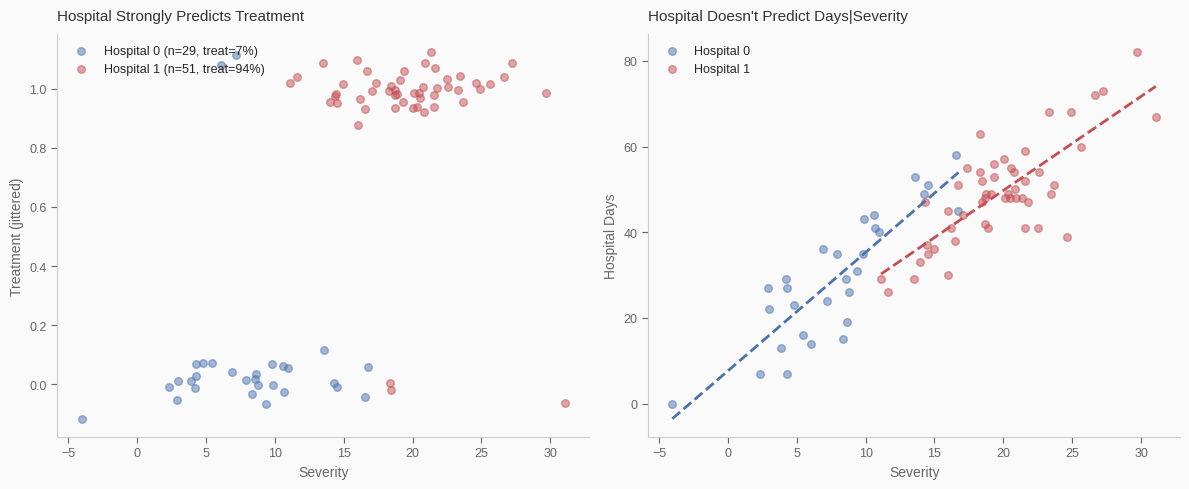

In [6]:
# Visualize the treatment variance reduction
fig, axes = create_tufte_figure(ncols=2, figsize=(12, 5))

# Left: Treatment variation by hospital
ax = axes[0]
for h_val, color, label in [(0, COLORS['blue'], 'Hospital 0'), (1, COLORS['red'], 'Hospital 1')]:
    subset = hospital[hospital['hospital'] == h_val]
    ax.scatter(subset['severity'], subset['treatment'] + np.random.normal(0, 0.05, len(subset)), 
               alpha=0.5, s=30, c=color, label=f'{label} (n={len(subset)}, treat={subset["treatment"].mean():.0%})')

set_tufte_title(ax, "Hospital Strongly Predicts Treatment")
set_tufte_labels(ax, "Severity", "Treatment (jittered)")
ax.legend(loc='upper left', frameon=False)

# Right: Outcome doesn't depend on hospital after severity
ax = axes[1]
for h_val, color, label in [(0, COLORS['blue'], 'Hospital 0'), (1, COLORS['red'], 'Hospital 1')]:
    subset = hospital[hospital['hospital'] == h_val]
    ax.scatter(subset['severity'], subset['days'], alpha=0.5, s=30, c=color, label=label)

# Add regression lines (parallel-ish)
for h_val, color in [(0, COLORS['blue']), (1, COLORS['red'])]:
    subset = hospital[hospital['hospital'] == h_val]
    m = smf.ols('days ~ severity', data=subset).fit()
    x_range = np.linspace(subset['severity'].min(), subset['severity'].max(), 100)
    ax.plot(x_range, m.params['Intercept'] + m.params['severity'] * x_range, 
            color=color, linewidth=2, linestyle='--')

set_tufte_title(ax, "Hospital Doesn't Predict Days|Severity")
set_tufte_labels(ax, "Severity", "Hospital Days")
ax.legend(loc='upper left', frameon=False)

plt.tight_layout()
plt.show()

In [7]:
# FWL: Show that controlling for hospital shrinks treatment variance

# Residualize T on severity only
T_resid_correct = smf.ols('treatment ~ severity', data=hospital).fit().resid

# Residualize T on severity + hospital
T_resid_bad = smf.ols('treatment ~ severity + hospital', data=hospital).fit().resid

print("Treatment Variance (FWL denominator):")
print(f"  Var(T):                    {hospital['treatment'].var():.4f}")
print(f"  Var(T̃|severity):           {T_resid_correct.var():.4f}")
print(f"  Var(T̃|severity,hospital):  {T_resid_bad.var():.4f}")
print(f"\nHospital removes {(1 - T_resid_bad.var()/T_resid_correct.var())*100:.1f}% of remaining T variance!")

Treatment Variance (FWL denominator):
  Var(T):                    0.2373
  Var(T̃|severity):           0.1378
  Var(T̃|severity,hospital):  0.0583

Hospital removes 57.7% of remaining T variance!


### Collider Bias (Different from SE Inflation)

A **collider** is a variable caused by both T and Y (or their descendants). Controlling for it opens a spurious path.

```
T → Collider ← Y
```

If we condition on the collider, T and Y become spuriously associated even if they have no causal relationship.

In [8]:
# Simulate collider bias
np.random.seed(42)
n = 1000

# T and Y are INDEPENDENT (no causal effect)
T = np.random.binomial(1, 0.5, n)
Y = np.random.normal(0, 1, n)  # Y has no relationship with T

# Collider is caused by BOTH T and Y
collider = T + Y + np.random.normal(0, 0.5, n)

sim_data = pd.DataFrame({'T': T, 'Y': Y, 'collider': collider})

# Without controlling for collider: correct (no effect)
model_no_collider = smf.ols('Y ~ T', data=sim_data).fit()

# WITH controlling for collider: BIASED (spurious negative effect)
model_with_collider = smf.ols('Y ~ T + collider', data=sim_data).fit()

print("COLLIDER BIAS DEMONSTRATION")
print("=" * 55)
print(f"True effect: 0 (T and Y are independent)")
print(f"\nEstimated effect of T on Y:")
print(f"  Without collider: {model_no_collider.params['T']:.3f} (p = {model_no_collider.pvalues['T']:.3f})")
print(f"  WITH collider:    {model_with_collider.params['T']:.3f} (p = {model_with_collider.pvalues['T']:.3f})")
print(f"\n→ Controlling for collider creates spurious NEGATIVE effect!")

COLLIDER BIAS DEMONSTRATION
True effect: 0 (T and Y are independent)

Estimated effect of T on Y:
  Without collider: -0.035 (p = 0.578)
  WITH collider:    -0.848 (p = 0.000)

→ Controlling for collider creates spurious NEGATIVE effect!


---

## Implementation

### Detecting Bad Controls

Before adding a control X, ask:

1. **Does X predict T?** (Check R²_{T~X})
2. **Does X predict Y after conditioning on confounders?** (Check partial correlation)
3. **Is X pre-treatment or post-treatment?** (Post-treatment often bad)
4. **Could X be a collider?** (Caused by T and Y)

In [9]:
def assess_control_quality(data, treatment, outcome, candidate, confounders=None):
    """
    Assess whether a candidate variable is a good or bad control.
    
    Parameters
    ----------
    data : pd.DataFrame
    treatment, outcome, candidate : str
        Column names.
    confounders : list of str, optional
        Known confounders already in the model.
        
    Returns
    -------
    dict with assessment results
    """
    confounders = confounders or []
    
    # 1. Does candidate predict T?
    if confounders:
        formula_T = f"{treatment} ~ {candidate} + {' + '.join(confounders)}"
    else:
        formula_T = f"{treatment} ~ {candidate}"
    model_T = smf.ols(formula_T, data=data).fit()
    r2_T = model_T.rsquared
    
    # 2. Does candidate predict Y after confounders?
    if confounders:
        formula_Y = f"{outcome} ~ {candidate} + {' + '.join(confounders)}"
    else:
        formula_Y = f"{outcome} ~ {candidate}"
    model_Y = smf.ols(formula_Y, data=data).fit()
    partial_r2_Y = model_Y.rsquared
    p_value_Y = model_Y.pvalues[candidate]
    
    # Assessment
    predicts_T = r2_T > 0.05
    predicts_Y = p_value_Y < 0.05
    
    if predicts_Y and not predicts_T:
        verdict = "GOOD: Predicts Y, not T → variance reduction"
    elif predicts_T and not predicts_Y:
        verdict = "BAD: Predicts T, not Y → SE inflation"
    elif predicts_T and predicts_Y:
        verdict = "MAYBE: Predicts both → check if confounder"
    else:
        verdict = "NEUTRAL: Predicts neither → no effect"
    
    return {
        'candidate': candidate,
        'R2_T': r2_T,
        'partial_R2_Y': partial_r2_Y,
        'p_value_Y': p_value_Y,
        'predicts_T': predicts_T,
        'predicts_Y': predicts_Y,
        'verdict': verdict
    }

# Test on hospital data
result = assess_control_quality(hospital, 'treatment', 'days', 'hospital', ['severity'])
print("Control Assessment for 'hospital':")
for k, v in result.items():
    print(f"  {k}: {v}")

Control Assessment for 'hospital':
  candidate: hospital
  R2_T: 0.7545425413456253
  partial_R2_Y: 0.7843643737629671
  p_value_Y: 0.00248018120482615
  predicts_T: True
  predicts_Y: True
  verdict: MAYBE: Predicts both → check if confounder


---

## Interview Appendix

### Practice Questions

**Q1: Can a variable be a bad control even if it's related to treatment?**

<details>
<summary>Solution</summary>

Yes! A variable that predicts treatment but **not outcome** (after conditioning on confounders) is a bad control.

**Why it hurts**:
- Removes treatment variation (reduces denominator in SE formula)
- Doesn't reduce residual variance (no benefit in numerator)
- Net effect: SE increases, precision decreases

**Example**: In our hospital data, hospital predicts which patients get treated (aggressive vs conservative hospital policy), but doesn't affect outcomes after controlling for severity. Including it removes "useful" variation in treatment.

</details>

**Q2: What's the difference between a bad control (SE inflation) and a collider (bias)?**

<details>
<summary>Solution</summary>

| Issue | Bad Control | Collider |
|-------|-------------|----------|
| **Problem** | Reduces precision | Introduces bias |
| **Mechanism** | Removes T variation | Opens spurious path |
| **DAG position** | X → T (but X ↛ Y\|confounders) | T → X ← Y |
| **Effect on β̂** | Same estimate, larger SE | Different (biased) estimate |
| **Severity** | Inefficiency (wider CI) | Invalidity (wrong answer) |

**Key distinction**: Bad controls make your estimate *less precise* but still correct on average. Colliders make your estimate *wrong*.

</details>

**Q3: How do you identify potential colliders in practice?**

<details>
<summary>Solution</summary>

**Timing heuristic**: Variables measured AFTER treatment are candidates for:
- Mediators (T → M → Y)
- Colliders (T → X ← Y)

**DAG reasoning**:
1. Draw your assumed causal graph
2. Check if X has arrows coming INTO it from both T and Y (or their descendants)
3. If yes, it's a collider

**Statistical hint**: If controlling for X makes a known null effect "significant", suspect collider bias.

**Example colliders**:
- Hospitalization (caused by both disease and severity of symptoms)
- Survey response (caused by both treatment group and outcome)
- Employment (caused by both education and ability)

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 7.

[^2]: Cinelli, C., Forney, A., & Pearl, J. (2020). A crash course in good and bad controls.

[^3]: Cross-reference: Collider discussion in `04_graphical_causal_models/03_selection_bias.ipynb`